# Reaction-diffusion models of biological invasions (Fisher KPP, heterogeneous domain & covariates, PINNs and SPINNs)

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r(x) - \gamma u(t,x)), t\geq 0, x\in [0, 1]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in [0,1]^2
\end{cases}
$$

In all that follows,$\gamma$ et $D$ are considered known constant but $r(x)$ is a unknown varying constant.

This notebook is inspired from [_Parameter estimation for reaction-diffusion models of biological invasions_](https://link.springer.com/article/10.1007/s10144-013-0415-0) by Soubeyrand and Roques, 2014. It contains $3$ sections:

1) General set up
2) PINN solving with RAR sampling and spatially heterogeneous $r$ parameter
3) PINN solving with RAR sampling and spatially heterogeneous $r$ parameter using covariates
4) SPINN solving
5) Conclusion (Speed avantage for the SPINNs!)

## 1) Imports and general set up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(2)


2024-10-04 17:35:58.080732: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 3, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jax.nn.softplus]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)


In [6]:
init_nn_params = u.init_params()


Create a DataGenerator object

In [7]:
n = 600
nb = 200
nt = 600
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 20
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

rar_parameters = {
    'start_iter':1000, # the gradient step at which RAR algo starts (enables a burn in period)
    'update_every': 1000, # nb of gradient steps between two RAR procedures
    'sample_size_times': 22, # the number of new candidates time points
    'selected_sample_size_times': 5, # the number of selected times collocation points from the sample, to join the dataset.
    'sample_size_omega': 22, # the number of new candidates space points
    'selected_sample_size_omega': 5,
}
n_start  = 400 # the initial number of spatial collocation points at beginning
nt_start = 400 # the initial number of temporal collocation points at beginning

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
    rar_parameters=rar_parameters,
    n_start=n_start,
    nt_start=nt_start
)

## Set up the initial condition

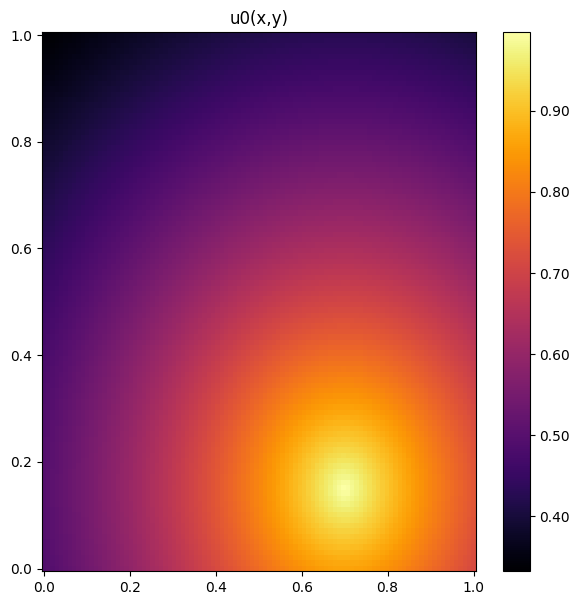

In [8]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.7, 0.15])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init))

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.plot.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)


## 1) Spatial heterogeneity of $r$

### True model parameters

We need to load the matrix containing the r values

In [9]:
D = 0.05
g = 1.
r1, r2, r3 = 0., -4., 2.


A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "D":jnp.array([D]),
        "r":jnp.array([r1, r2, r3]),
        "g":jnp.array([g])
    }
)


The spatial heterogeneity of $r$ is introduced through a user defined function which recreates the spatial map

In [11]:
def r_fun(t, x, _, params):
    """ must be a jittable function """
    eq_params = params.eq_params
    r1, r2, r3 = eq_params["r"]
    return jax.lax.switch(
        jnp.amax(
            jnp.nonzero(
                jnp.array([
                    True,
                    jnp.logical_or(
                        jnp.logical_and(x[0] > 6 / 20, x[0] < 8 / 20),
                        jnp.logical_and(x[1] > 8 / 20, x[1] < 10 / 20)
                    ),
                    jnp.logical_or(
                        (x[0] - 0.15)**2 + (x[1] - 0.15)**2 < 0.015,
                        (x[0] - 0.8)**2 + (x[1] - 0.80)**2 < 0.03
                    )
                ]),
                size=3
            )[0]
        ),
        [lambda _:r1, lambda _:r2, lambda _:r3],
        ()
    )


Let's visualize the spatial heterogeneity map that we have just created:

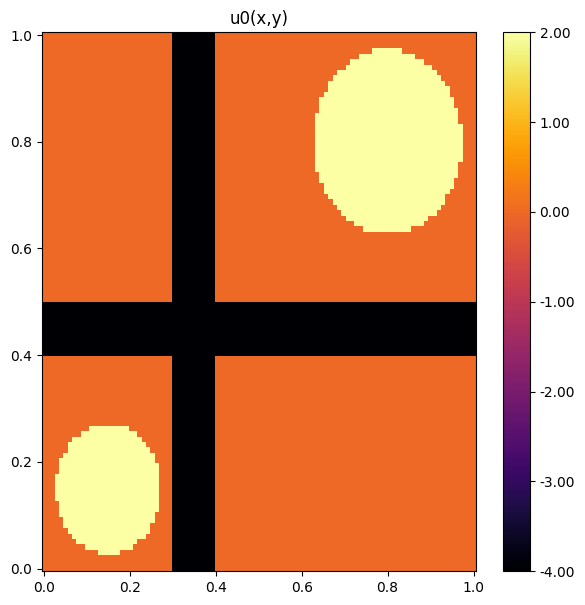

In [12]:
nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.plot.plot2d(
    fun=lambda x: r_fun(None, x, None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)"
)


### Loss construction
Create the Reaction Diffusion 2D loss. The loss contains **heterogeneous parameters** that can be managed in two steps:

1. Define a dictionary `eq_params_heterogeneity` with any kind of functions that should be applied to the equation parameters. Here, the $r$ coefficient is varies spatially according to the `r_fun` defined above. Note that whatever the transform, the arguments of the such a function must be `t, x, u, params` in the stationary case.

2. Transform the parameters according to the content of the dictionary `eq_params_heterogeneity` at each call of `evaluate`. This can be done simply by decorating the `evaluate()` method with `@evaluate_heterogeneous_parameters` (since we use a predefined dynamic loss, the decorator is already set; check out the FisherKPP loss class in `jinns/loss/_DynamicLoss.py`). The equivalent code of such decorator would be:
```
params["eq_params"] = self.eval_heterogeneous_parameters(
     t, x, u, params, self.eq_params_heterogeneity)
```

In [13]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D":None, "r":r_fun, "g":None}
)


In [15]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1,
    initial_condition= 1 * Tmax,
    boundary_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0
)


In [16]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()[1]
)


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 4.283717155456543
Individual losses: {'boundary_loss': '0.76', 'dyn_loss': '3.47', 'initial_condition': '0.05', 'norm_loss': '0.00', 'observations': '0.00'}


### Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [17]:
params = init_params


In [18]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)


In [19]:
n_iter = 50000


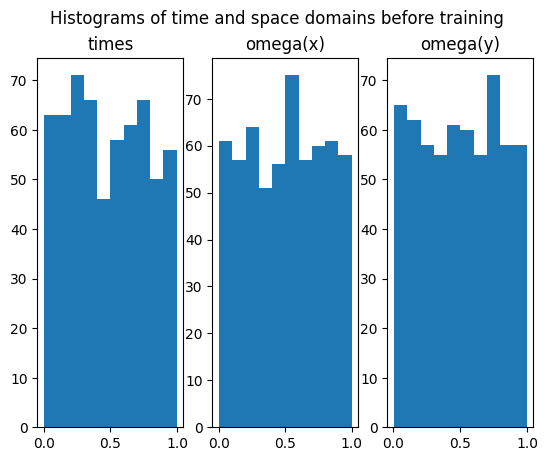

In [20]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains before training')
plt.show()

In [21]:
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
end = time.time()

[train] Iteration 0: loss value = 5.542550086975098
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 5.542550086975098


In [22]:
time_1 = end - start
print("Time 1", time_1)

Time 1 15.17732286453247


### Results

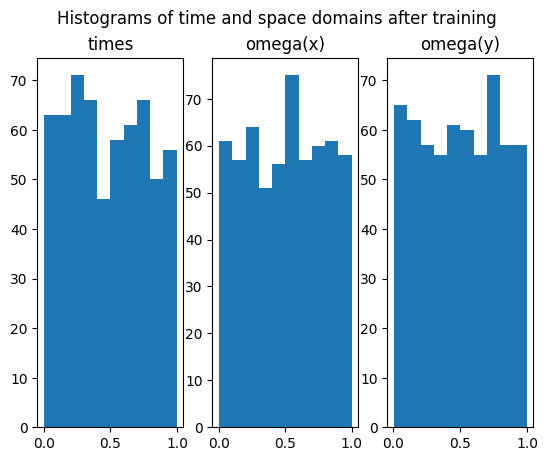

In [23]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains after training')
plt.show()


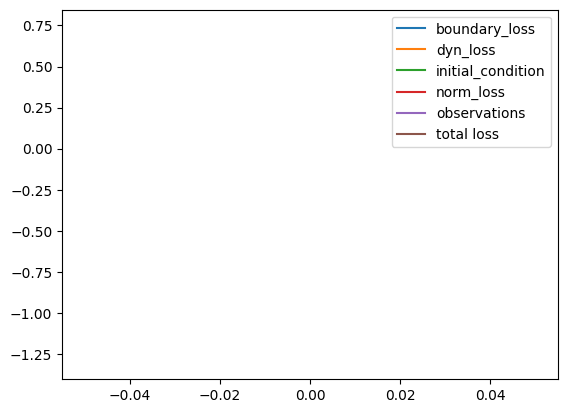

In [24]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solution learned by the PINN

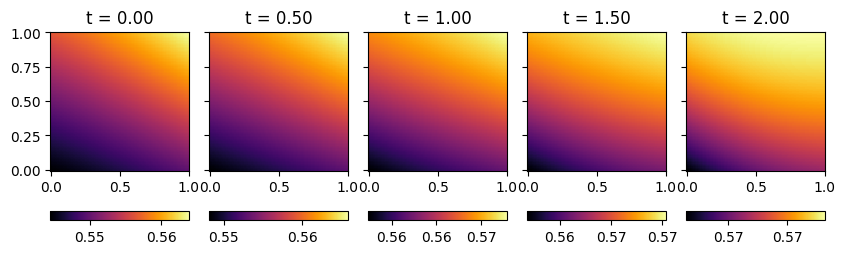

In [25]:
times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time susescale
u_est = lambda t, x: u(t, x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)


## 2) Spatial heterogeinity of $r$ through a GLM 

This section is inspired from mechanico-statistical model in ecology as e.g.
 [this article](https://www.sciencedirect.com/science/article/pii/S2211675320300221?via%3Dihub) 
 and [accompanying code](https://github.com/oliviergimenez/appendix_mecastat/blob/01a89e8d2506849b28ec9da6fa7dec0a3be61050/mecastat_simulations.R#L127)). 

Let us say that we have access to an addition spatial covariate, $c(x)$ 
which corresponds to forest covering at position $x$. We make the hypothesis 
that the reproduction rate $r(x)$ spatially depends on $c(x)$ through the 
following logistic link
$$
  r(x) = \frac{1}{1 + e^{\beta_0 + \beta_1 c(x) + \beta_2 c(x)^2}}
$$

Here, $\beta$ is supposed known and fixed but one could optimize w.r.t to 
$\beta$ in inverse problem settings.

In [26]:
D = 0.05
g = 1.
r0 = 0.

init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "D":jnp.array([D]),
        "r":jnp.array([r0]),
        "g":jnp.array([g]),
        "beta":jnp.array([-2., 1., 5.])
    }
)

We now specify how we get the covariate value at point $x$. Here, we say say the covariate is accessible everywhere and disposed on a map (for simplicity we take the same as before).

In [27]:
def covariate(x):
    """ must be a jittable function """
    f1, f2, f3 = 0.5, 0.0, 0.9
    return jax.lax.switch(
        jnp.amax(
            jnp.nonzero(
                jnp.array([
                    True,
                    jnp.logical_or(
                        jnp.logical_and(x[0] > 6 / 20, x[0] < 8 / 20),
                        jnp.logical_and(x[1] > 8 / 20, x[1] < 10 / 20)
                    ),
                    jnp.logical_or(
                        (x[0] - 0.15)**2 + (x[1] - 0.15)**2 < 0.015,
                        (x[0] - 0.8)**2 + (x[1] - 0.80)**2 < 0.03
                    )
                ]),
                size=3
            )[0]
        ),
        [lambda _:f1, lambda _:f2, lambda _:f3],
        ()
    )


In [28]:
def r_fun(t, x, _, params):
    """ must be a jittable function """
    # t is never used here since no temporal modeling
    # but we could have covariate(t, x) in a non-stationary setting
    c = covariate(x)
    return jax.nn.sigmoid(jnp.sum(params.eq_params["beta"] * jnp.array([1, c, c ** 2])))


Text(0.5, 1.0, 'Generalized linear model: $b(r) = \\beta^\\top (1, c, c^2)$.')

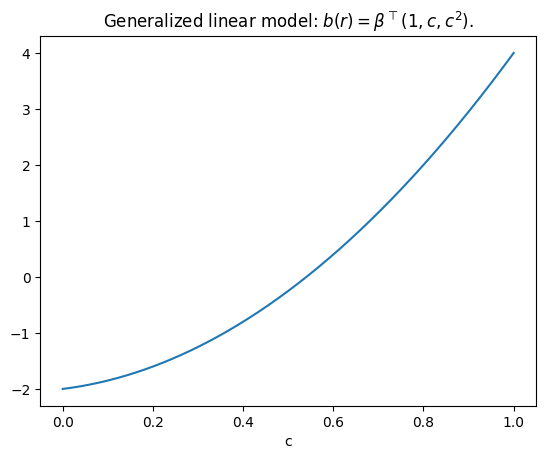

In [30]:
cs = jnp.linspace(0, 1, 1000)
plt.plot(cs, vmap(lambda c: jnp.sum(init_params.eq_params["beta"] * jnp.array([1, c, c ** 2])))(cs))
plt.xlabel(r"c")
plt.title(r"Generalized linear model: $b(r) = \beta^\top (1, c, c^2)$.")


Let's visualize the growth rate that is obtained throught this link:

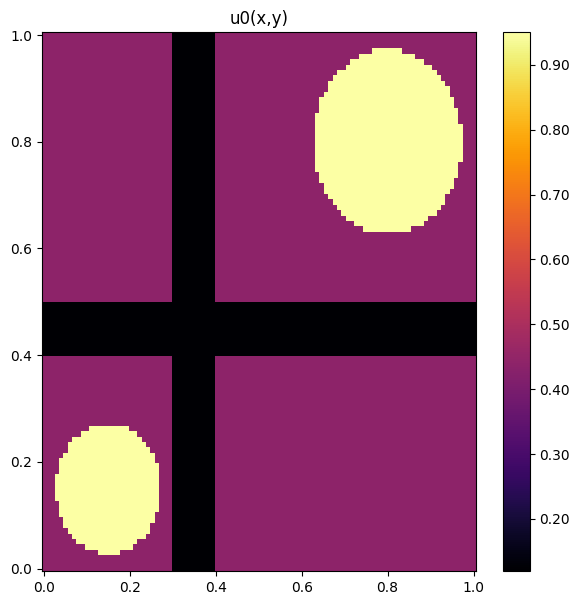

In [31]:
nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]


jinns.plot.plot2d(
    fun=lambda x: r_fun(None, x, None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)"
)


Then the rest follows as in the previous section

In [32]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D":None, "r":r_fun, "g":None}
)


In [33]:
# recreate train_data because rar_sampling was previously used on another
# problem => reset the collocation points
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [34]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=10,
    initial_condition=1 * Tmax,
    boundary_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0
)


In [35]:
params = init_params
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)
n_iter = 50000

start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
end = time.time()

[train] Iteration 0: loss value = 1.9520646333694458
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 1.9520646333694458


In [36]:
time_2 = end - start
print("Time 2", time_2)

Time 2 10.715215682983398


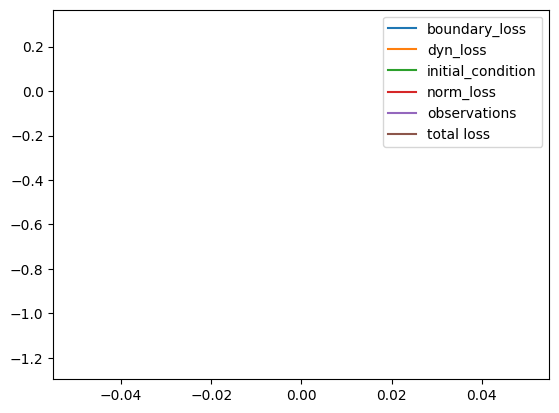

In [37]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


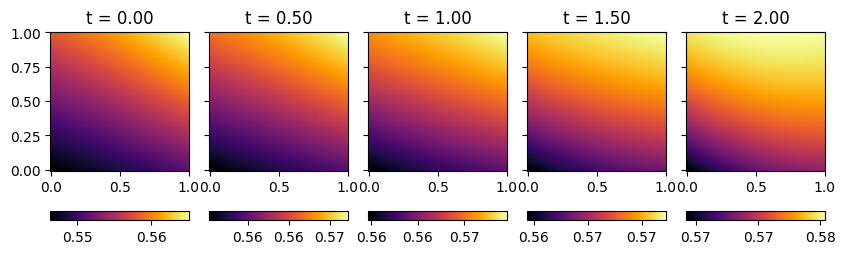

In [38]:
times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time susescale
u_est = lambda t, x: u(t, x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)


## 3) Separable PINNs
In this section, we run experiments in the same context but with [Separable PINNs](https://openreview.net/pdf?id=dEySGIcDnI).

Note the `cartesian_product=False` in the cell below, which tells the `train_data_spinn` DataGenerator not to output cartesian product of space and time collocation points. It is because we use a separable PINN (SPINN) which already does similar operations internally (more precisely, outer products of each axis-dimension). 

In [39]:
d = 3
r = 256
eqx_list = (
    (eqx.nn.Linear, 1, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, r),
)
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")
init_nn_params_spinn = u_spinn.init_params()

# Reset train_data: here we do not use RAR sampling as it is not implemented
# for separable-PINNs
n = 600
nb = 600
nt = 600
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
    cartesian_product=False # Note that the train_data_spinn DataGenerator will not output cartesian product of space and time collocation points.
)

### Set up the initial condition

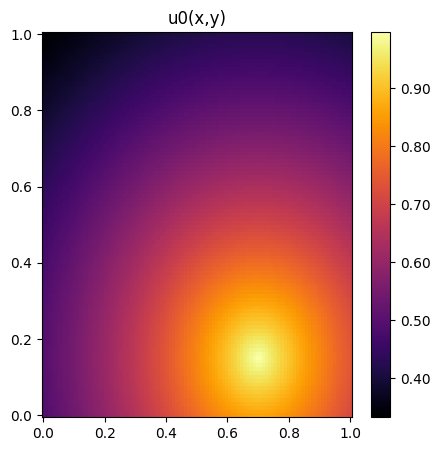

In [40]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.7, 0.15])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init, axis=-1))

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.plot.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)",
    figsize=(5, 5)
)

### Define the parameters and the spatial heterogeneity of $r$

In [41]:
D = 0.05
g = 1.
r1, r2, r3 = 0., -4., 2.

In [42]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params_spinn,
    eq_params={
        "D":jnp.array([D]),
        "r":jnp.array([r1, r2, r3]),
        "g":jnp.array([g])
    }
)

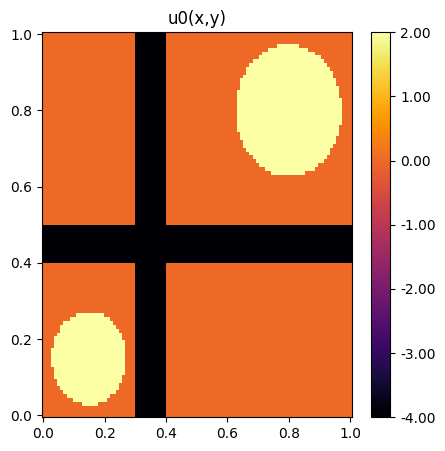

In [43]:
from jinns.utils._utils import _get_grid

def r_fun(t, x, _, params):
    """ must be a jittable function """
    x = _get_grid(x.squeeze())
    eq_params = params.eq_params
    r1, r2, r3 = eq_params["r"]

    # # Next is required to be able to call plot_2D and see the map
    # if x.shape[0] != x.shape[1]:
    #     x = _get_grid(x.squeeze())

    # By default put r1 everywhere
    r_map_batch = jnp.full(x.shape[:2], r1)
    # But if the next cond is True, update to r2
    r_map_batch = jnp.where(
        jnp.logical_or(
            jnp.logical_and(x[..., 0] > 6 / 20, x[..., 0] < 8 / 20),
            jnp.logical_and(x[..., 1] > 8 / 20, x[..., 1] < 10 / 20)
        ),
        r2,
        r_map_batch
    )
    # Again if the next cond is True, update to r3
    r_map_batch = jnp.where(
        jnp.logical_or(
                        (x[..., 0] - 0.15)**2 + (x[..., 1] - 0.15)**2 < 0.015,
                        (x[..., 0] - 0.8)**2 + (x[..., 1] - 0.80)**2 < 0.03
        ),
        r3,
        r_map_batch
    )
    return r_map_batch

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.plot.plot2d(
    fun=lambda x: r_fun(None, x, None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)",
    spinn=True,
    figsize=(5, 5)
)

### Construct the loss

In [44]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D":None, "r":r_fun, "g":None}
)
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, 
    initial_condition=1 * Tmax,
    boundary_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0,
)

### Learning

In [45]:
params = init_params
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 2500
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
end = time.time()

[train] Iteration 0: loss value = 0.9248219728469849
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 0.9248219728469849


In [46]:
time_3 = end - start
print("Time 3", time_3)

Time 3 27.86386466026306


### Results

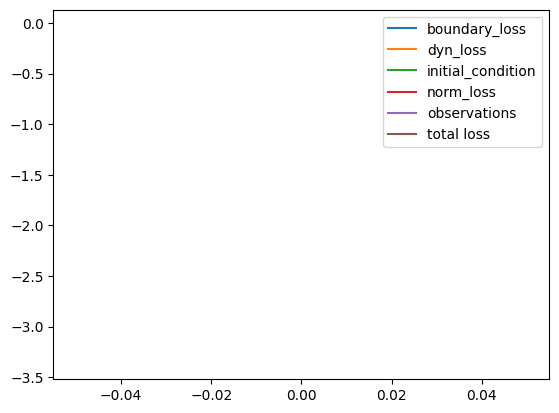

In [47]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

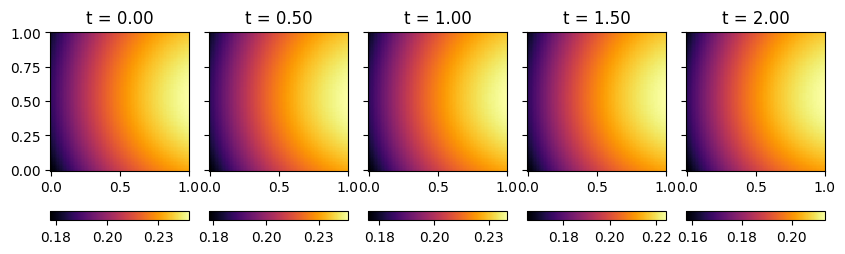

In [48]:
times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time susescale
u_est = lambda t, x: u_spinn(t, x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

### Solving for different initial conditions

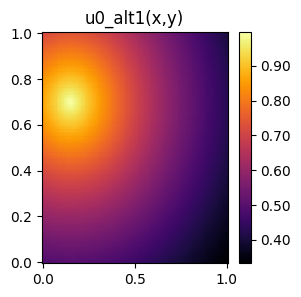

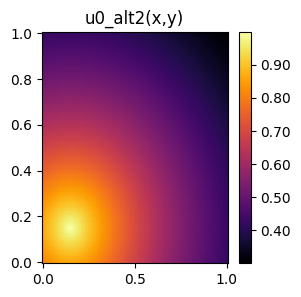

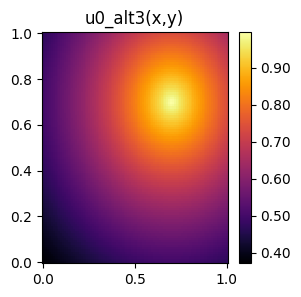

In [49]:
from jax.scipy.stats import norm
def u0_alt1(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.15, 0.7]), axis=-1))
jinns.plot.plot2d(
    fun=u0_alt1,
    xy_data=val_xy_data,
    title="u0_alt1(x,y)",
    figsize=(3, 3)
)
def u0_alt2(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.15, 0.15]), axis=-1))
jinns.plot.plot2d(
    fun=u0_alt2,
    xy_data=val_xy_data,
    title="u0_alt2(x,y)",
    figsize=(3, 3)
)
def u0_alt3(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.7, 0.7]), axis=-1))
jinns.plot.plot2d(
    fun=u0_alt3,
    xy_data=val_xy_data,
    title="u0_alt3(x,y)",
    figsize=(3, 3)
)

[train] Iteration 0: loss value = 0.8118515610694885
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 0.8118515610694885


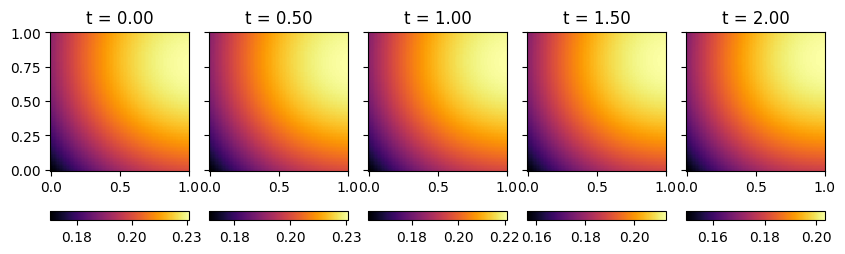

In [50]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0_alt1,
)
params = init_params
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
end = time.time()
u_est = lambda t, x: u_spinn(t, x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

In [51]:
time_4 = end - start
print("Time 4", time_4)

Time 4 17.481690168380737


[train] Iteration 0: loss value = 0.7414491176605225
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 0.7414491176605225


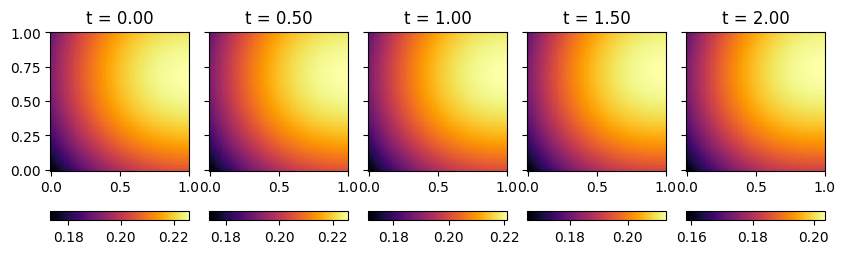

In [52]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0_alt2,
)
params = init_params
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
end = time.time()
u_est = lambda t, x: u_spinn(t, x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

In [53]:
time_5 = end - start
print("Time 5", time_5)

Time 5 16.77452278137207


[train] Iteration 0: loss value = 0.9393965601921082
Stopping main optimization loop, cause: max iteration is reached
Final iteration 1: train loss value = 0.9393965601921082


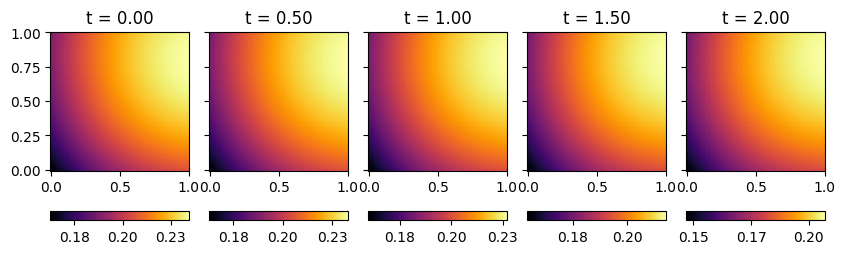

In [55]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0_alt3,
)
params = init_params
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)
end = time.time()
u_est = lambda t, x: u_spinn(t, x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    figsize=(10, 10*len(times)),
    spinn=True
)

In [56]:
time_5 = end - start
print("Time 5", time_5)

Time 5 24.243521213531494


## 5) Conclusion

We have solved this Fisher KPP PDE tackling parameter heterogeneity and with both the PINN and SPINN approaches. Both approaches seem to converge quite efficiently towards the solution but a speed advantage goes towards the SPINNs (given batches of the same sizes and total number of collocation points -up to the few points added in RAR-). Note that SPINNs require less iterations to reach convergence. We report the progress bars for each learning part:

XXXXX

(Times obtained on GPU Nvidia T600)